In [1]:
import datasets
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

/home/yvson/Documents/Faculdade/NLP/NLP-final-project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("ag_news")

In [3]:
def get_balanced_dataset(dataset, percentage):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
    dataset = pd.DataFrame(dataset)
    dataset = dataset[['text', 'label']]
    dataset = dataset.groupby("label").apply(lambda x: x.sample(frac=percentage)).reset_index(drop=True)
    return dataset

In [4]:
Categories = ["World", "Sports", "Business", "Sci/Tech"]
Categories

['World', 'Sports', 'Business', 'Sci/Tech']

In [5]:
perc_train = 0.20
perc = 0.20

train_df = get_balanced_dataset(dataset["train"], perc_train)
teste_df = get_balanced_dataset(dataset["test"], perc)

# training_set = list(zip(train_df["text"], train_df["label"]))
# test_set = list(zip(teste_df["text"], teste_df["label"]))

In [6]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(train_df["text"].to_list())
tfidf_test = tfidf_vectorizer.transform(teste_df["text"].to_list())

train_df['text_tfdif'] = list(tfidf_train.toarray())
teste_df['text_tfdif'] = list(tfidf_test.toarray())

In [7]:
train_df

,text,label,text_tfdif
0,EU Leaders Poised to Offer Entry Talks to Turk...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Russia boosts funds for security Russia is to ...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,State Dept. Official Arrested in Inquiry on Ta...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Voters Dislike Nasty Campaigns (AP) AP - Near ...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Caesarean 'low birth risk link' Women opting f...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
23995,Where's the spark on power line Net? The NYT h...,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
23996,Computer Users Face New Scourge Millions of co...,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
23997,Bouygues and Vivendi in mobile deal PARIS Bouy...,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
23998,Powell: Feds must use light touch on Net FCC c...,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [8]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(list(train_df["text_tfdif"]), train_df["label"])

LogisticRegression()

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

y_hat = model.predict(list(teste_df["text_tfdif"]))
y_test = teste_df["label"].to_list()

In [10]:
#compute accuracy
accuracy = sum([y_hat[i] == y_test[i] for i in range(len(y_test))]) / len(y_test)
print(f"Accuracy: {accuracy}")

#compute recall
recall = recall_score(y_test, y_hat, average='macro')
print(f"Recall: {recall}")

#compute precision
precision = precision_score(y_test, y_hat, average='macro')
print(f"Precision: {precision}")

#compute f1 score
f1 = f1_score(y_test, y_hat, average='macro')
print(f"F1 Score: {f1}")

Accuracy: 0.9039473684210526
Recall: 0.9039473684210526
Precision: 0.9037339821663412
F1 Score: 0.9037599434401578


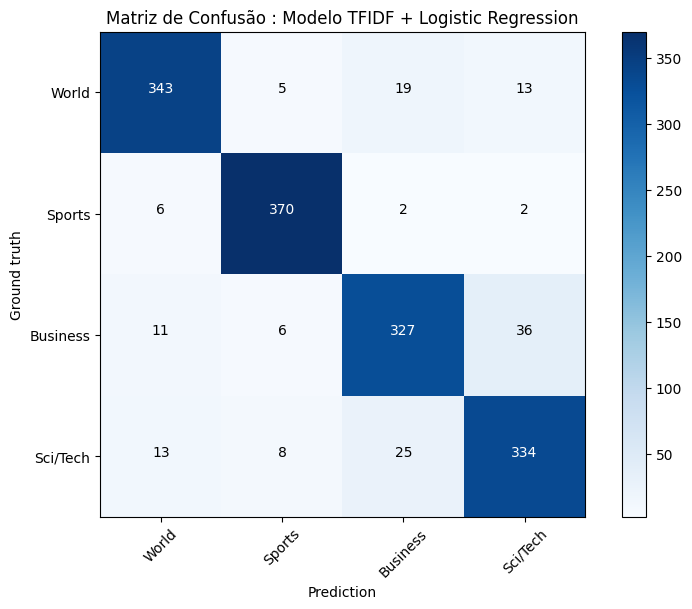

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(y_test, y_hat)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão : Modelo TFIDF + Logistic Regression')
plt.colorbar()


tick_marks = np.arange(len(Categories))
plt.xticks(tick_marks, Categories, rotation=45)
plt.yticks(tick_marks, Categories)


thresh = conf_matrix.max() / 2.
for i, j in [(i, j) for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])]:
    plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Ground truth')
plt.xlabel('Prediction')
plt.show()